In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from efficientnet_pytorch import EfficientNet
from PIL import Image
from tqdm import tqdm


  Preparing metadata (setup.py) ... done


In [ ]:
DATASET_DIR = "/dataset" 

data.yaml  test  train	val


In [ ]:
class AffectNetDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.files = [
            f for f in os.listdir(images)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images, img_name)
        image = Image.open(img_path).convert("RGB")

        label_name = img_name.rsplit(".", 1)[0] + ".txt"
        label_path = os.path.join(self.labels, label_name)

        with open(label_path, "r") as f:
            class_id = int(f.readline().split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_id


In [ ]:
IMG_SIZE = 224
BATCH = 32

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_dataset = AffectNetDataset(f"{DATASET_DIR}/train/images", f"{DATASET_DIR}/train/labels", train_tf)
val_dataset   = AffectNetDataset(f"{DATASET_DIR}/val/images",   f"{DATASET_DIR}/val/labels",   val_tf)
test_dataset  = AffectNetDataset(f"{DATASET_DIR}/test/images",  f"{DATASET_DIR}/test/labels",  val_tf)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset), len(test_dataset)


(17101, 5406, 2755)

In [ ]:
unique_classes = set()

for _, label in train_dataset:
    unique_classes.add(label)

NUM_CLASSES = len(unique_classes)
NUM_CLASSES


8

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained("efficientnet-b0")
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 148MB/s]


Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0, 0, 0

    loop = tqdm(loader, desc="Training", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    loop = tqdm(loader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    return running_loss / total, correct / total


In [ ]:
EPOCHS = 12
best_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    scheduler.step()

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss={tr_loss:.4f}, Acc={tr_acc:.4f}")
    print(f"Val   Loss={val_loss:.4f}, Acc={val_acc:.4f}\n")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "efficientnet_best.pth")
        print("✔ Saved Best Model")

# SAVE TRAINING HISTORY
np.savez("training_history.npz",
         train_losses=train_losses,
         val_losses=val_losses,
         train_accs=train_accs,
         val_accs=val_accs)



Epoch 1/12


Train Loss=1.3586, Acc=0.4935
Val   Loss=1.0020, Acc=0.6263

✔ Saved Best Model

Epoch 2/12


Train Loss=0.9207, Acc=0.6572
Val   Loss=0.8838, Acc=0.6681

✔ Saved Best Model

Epoch 3/12


Train Loss=0.7391, Acc=0.7267
Val   Loss=0.8130, Acc=0.6946

✔ Saved Best Model

Epoch 4/12


Train Loss=0.5963, Acc=0.7785
Val   Loss=0.8418, Acc=0.6957

✔ Saved Best Model

Epoch 5/12


Train Loss=0.4884, Acc=0.8212
Val   Loss=0.8531, Acc=0.7064

✔ Saved Best Model

Epoch 6/12


Train Loss=0.3580, Acc=0.8771
Val   Loss=0.8178, Acc=0.7109

✔ Saved Best Model

Epoch 7/12


Train Loss=0.3233, Acc=0.8939
Val   Loss=0.8311, Acc=0.7101


Epoch 8/12


Train Loss=0.3145, Acc=0.8957
Val   Loss=0.8446, Acc=0.7125

✔ Saved Best Model

Epoch 9/12


Train Loss=0.2983, Acc=0.8954
Val   Loss=0.8549, Acc=0.7122


Epoch 10/12


Train Loss=0.2963, Acc=0.8974
Val   Loss=0.8570, Acc=0.7120


Epoch 11/12


Train Loss=0.2754, Acc=0.9066
Val   Loss=0.8595, Acc=0.7118


Epoch 12/12


Train Loss=0.2780, Acc=0.9056
Val   Loss=0.8599, Acc=0.7103



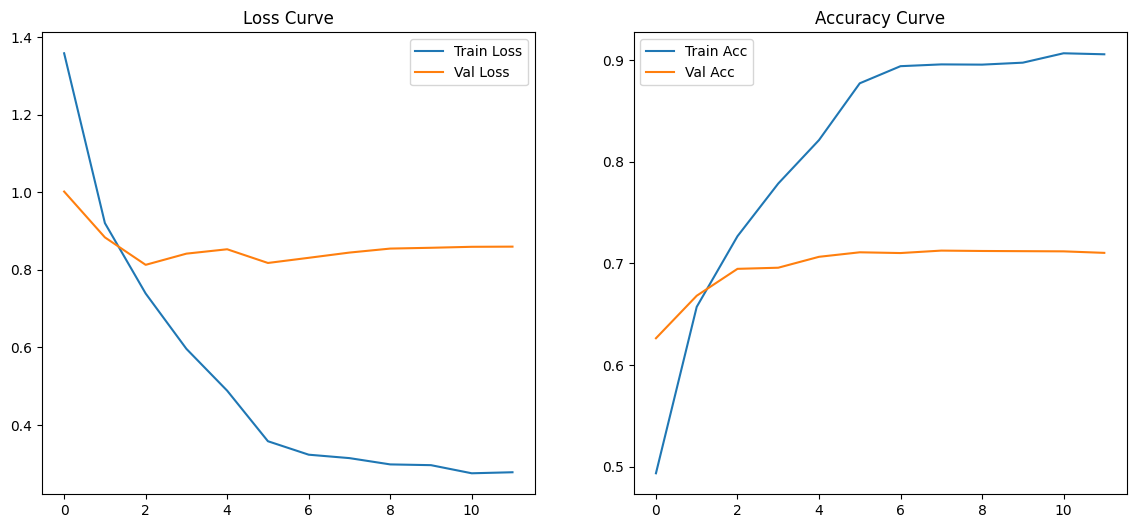

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


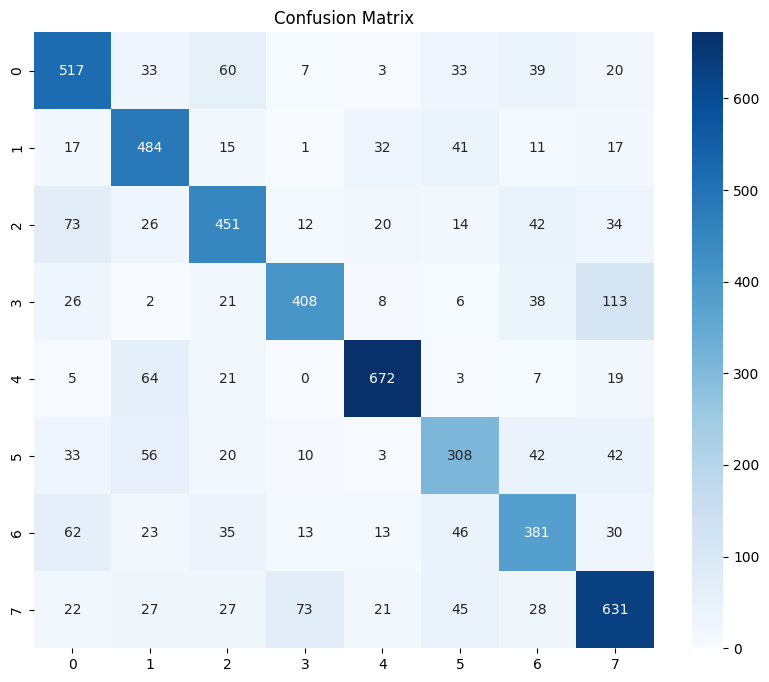

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       712
           1       0.68      0.78      0.73       618
           2       0.69      0.67      0.68       672
           3       0.78      0.66      0.71       622
           4       0.87      0.85      0.86       791
           5       0.62      0.60      0.61       514
           6       0.65      0.63      0.64       603
           7       0.70      0.72      0.71       874

    accuracy                           0.71      5406
   macro avg       0.71      0.70      0.71      5406
weighted avg       0.71      0.71      0.71      5406



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# reload best model
model.load_state_dict(torch.load("efficientnet_best.pth"))
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, pred_labels))


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Load best model
# -----------------------------
model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(model._fc.in_features, NUM_CLASSES)

model.load_state_dict(torch.load("efficientnet_best.pth", map_location=device))
model.to(device)  # 🔥 IMPORTANT FIX

model.eval()

criterion = nn.CrossEntropyLoss()

# -----------------------------
# Evaluate on Test Set
# -----------------------------
test_loss, test_correct, total = 0, 0, 0
loop = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, labels in loop:
        images = images.to(device)   # 🔥 FIX
        labels = labels.to(device)   # 🔥 FIX

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        test_correct += (preds == labels).sum().item()
        total += labels.size(0)

# -----------------------------
# Final Metrics
# -----------------------------
test_loss /= total
test_acc = test_correct / total

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Using device: cuda
Loaded pretrained weights for efficientnet-b0


Testing: 100%|██████████| 87/87 [00:10<00:00,  8.69it/s]


Test Loss: 0.8725
Test Accuracy: 0.7136


In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

# -----------------------------
# SET THESE
# -----------------------------
IMAGE_PATH = "/content/ffhq_1002.png"   # <-- change this
NUM_CLASSES = 8                                         # <-- your class count

# Emotion labels (edit for your dataset)
EMOTIONS = {
    0: "Neutral",
    1: "Happy",
    2: "Sad",
    3: "Angry",
    4: "Fear",
    5: "Disgust",
    6: "Surprise",
    7: "Contempt"
}

# -----------------------------
# DEVICE
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------------
# Load model
# -----------------------------
model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(model._fc.in_features, NUM_CLASSES)

model.load_state_dict(torch.load("efficientnet_best.pth", map_location=device))
model.to(device)
model.eval()

# -----------------------------
# Transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# -----------------------------
# Inference function
# -----------------------------
def predict_image(path):
    img = Image.open(path).convert("RGB")

    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(x)
        _, pred = torch.max(output, 1)

    class_id = pred.item()
    emotion = EMOTIONS.get(class_id, f"Class {class_id}")

    return class_id, emotion

# -----------------------------
# Run inference
# -----------------------------
class_id, emotion = predict_image(IMAGE_PATH)
print("Predicted Class ID:", class_id)
print("Predicted Emotion:", emotion)


Using: cuda
Loaded pretrained weights for efficientnet-b0
Predicted Class ID: 5
Predicted Emotion: Disgust
